# Anomaly Detection

使用高斯模型来检测数据集中未标记的示例是否应被视为异常。

In [1]:
from utils import *

# Load Data

In [2]:
mat = loadmat('data/ex8data1.mat')
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [3]:
X = mat['X']
Xval, Xtest, yval, ytest = train_test_split(mat['Xval'], mat['yval'], test_size=0.5)

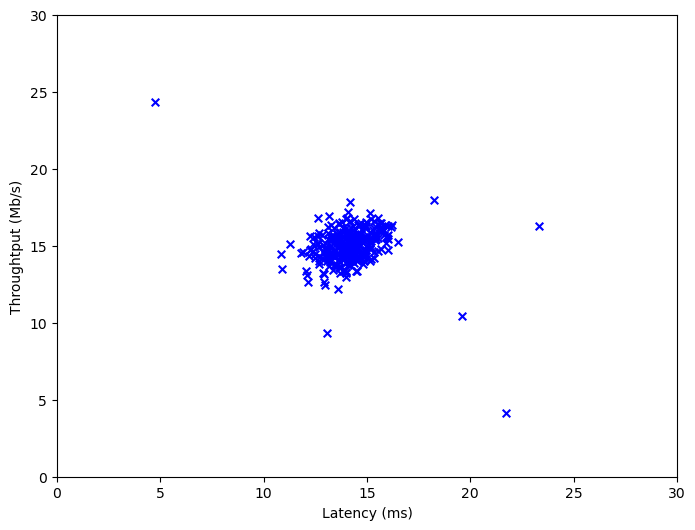

In [4]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughtput (Mb/s)')
ax.set_xlim(0, 30)
ax.set_ylim(0, 30)
ax.scatter(X[:,0], X[:, 1], marker='x', c='b', s=30)
plt.show()

# Gaussian Distribution
概率密度函数（PDF）:
\begin{equation}
p(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp\left(-\frac{(x-\mu)^2}{2\sigma^2}\right)
\end{equation}

\begin{equation}
\mu_j = \frac{1}{m}\sum_{i=1}^{m}x^{(i)}_j
\end{equation}

\begin{equation}
\sigma^2_j = \frac{1}{m}\sum_{i=1}^{m}\left ( x^{(i)}_j - \mu_j \right ) ^ 2
\end{equation}

In [5]:
mu = X.mean(axis=0)
mu

array([14.11222578, 14.99771051])

In [6]:
sigma2 = np.sum((X - mu) ** 2, axis=0) / X.shape[0]
sigma2

array([1.83263141, 1.70974533])

\begin{equation}
coefficient = \frac{1}{(2\Pi)^{d/2}\sqrt{\prod \sigma_i^2}}
\end{equation}

\begin{equation}
exponent = -\frac{1}{2}\sum_{i=1}^{d}\frac{(x_i - \mu_i)^2}{\sigma_i^2}
\end{equation}

In [7]:
def pdf(x, mu, sigma2):
    """
    计算对角协方差矩阵的多维高斯分布概率密度函数
    参数:
        x: 网格数据，形状为 (m, n, d)
        mu: 均值向量，形状为 (d,)
        sigma2: 方差向量，形状为 (d,)
    返回:
        概率密度值，形状为 (m, n)
    """
    d = mu.shape[0]  # 数据维度
    # np.prod 计算所有元素的乘积
    coefficient = 1 / ( (2 * np.pi) ** (d/2) * np.sqrt(np.prod(sigma2)) )
    exponent = -0.5 * np.sum( (x - mu)**2 / sigma2, axis=2 )
    return coefficient * np.exp(exponent)

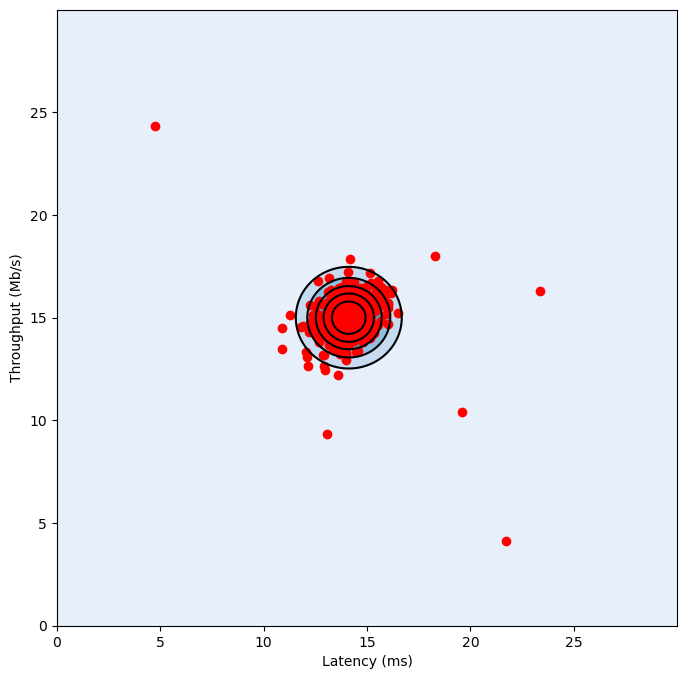

In [8]:
# Generate grid
x, y = np.mgrid[0:30:0.01, 0:30:0.01]
pos = np.dstack((x, y))
# Create plot
fig, ax = plt.subplots(figsize=(8, 8))

# Plot PDF contours
pdf_values = pdf(pos, mu, sigma2)
ax.contourf(x, y, pdf_values, cmap='Blues')
ax.contour(x, y, pdf_values, colors='black')

# Plot data points (assuming X is defined elsewhere)
ax.scatter(X[:, 0], X[:, 1], c='r')

ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (Mb/s)')
plt.show()

## Multivariate Gaussian Parameters

In [9]:
cov = np.cov(X, rowvar=False)
cov

array([[ 1.83862041, -0.22786456],
       [-0.22786456,  1.71533273]])

In [10]:
# 创建一个多维正态分布（多元高斯分布）的概率分布对象
multi_normal = stats.multivariate_normal(mean=mu, cov=cov)

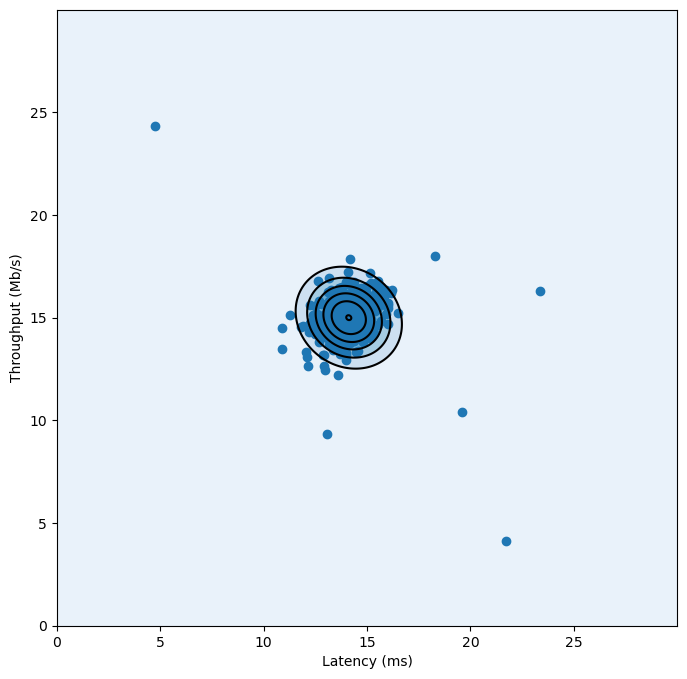

In [11]:
multi_normal_pdf_value = multi_normal.pdf(pos)
fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(x, y, multi_normal_pdf_value, cmap='Blues')
ax.contour(x, y, multi_normal_pdf_value, colors='black')

ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (Mb/s)')
ax.scatter(X[:, 0], X[:, 1])

plt.show()

# Select Threshold

算法步骤总结：
**初始化**：候选 ε 值范围（如 `np.linspace(min(pval), max(pval), 1000)`）。

**循环计算**：
    对每个 ε：
-   预测标签：`y_pred = (pval < ε).astype(int)`。
-   计算 真阳性 (tp)、假阳性 (fp)、假阴性 (fn)。
-   计算 精确率 (prec) 和召回率 (rec)，进而计算 F1分数。

**选择最优**：记录最大 F1 对应的 ε。

精确率 (Precision)
$$
\text{prec} = \frac{\text{tp}}{\text{tp} + \text{fp}}
$$
召回率 (Recall)
$$
\text{rec} = \frac{\text{tp}}{\text{tp} + \text{fn}}
$$
F1 分数
$$
F_1 = \frac{2 \cdot \text{prec} \cdot \text{rec}}{\text{prec} + \text{rec}}
$$

In [12]:
def select_threshold(X, Xval, yval):
    '''
    使用交叉验证数据选择最佳异常检测阈值
    返回:
        best_epsilon: 最佳阈值（F1分数最高）
        best_f1: 对应的F1分数
    '''
    # 估计多元高斯分布参数（添加正则化防止协方差矩阵奇异）
    mu = np.mean(X, axis=0)
    cov = np.cov(X.T) + 1e-6 * np.eye(X.shape[1])  # 添加小量对角线元素
    multi_normal = stats.multivariate_normal(mean=mu, cov=cov)

    # 计算验证集的概率密度
    pval = multi_normal.pdf(Xval)

    # 生成候选阈值（集中在低概率区域）
    epsilon = np.linspace(np.min(pval), np.max(pval), 10000)

    best_epsilon = 0
    best_f1 = 0

    for e in epsilon:
        # 预测异常（pval < epsilon）
        y_pred = (pval < e).astype(int)  # 使用 < 而非 <=
        current_f1 = f1_score(yval, y_pred, zero_division=0)

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_epsilon = e

    return best_epsilon, best_f1

In [13]:
e, fs = select_threshold(X, Xval, yval)
print('Best epsilon: {}\nBest F-score on validation data: {}'.format(e, fs))

Best epsilon: 3.603074424300807e-05
Best F-score on validation data: 0.8


In [14]:
def predict (X, Xval, e, Xtest, ytest):
    '''
    Returns:
        multi_normal: multivariate normal model
        y_pred: prediction of test data
    '''

    Xdata = np.concatenate((X, Xval), axis=0)
    mu = Xdata.mean(axis=0)
    cov = np.cov(Xdata.T)
    multi_normal = stats.multivariate_normal(mu, cov)

    pval = multi_normal.pdf(Xtest)
    y_pred = (pval < e).astype('int')
    print(classification_report(ytest, y_pred))

    return multi_normal, y_pred

In [15]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       151
           1       1.00      1.00      1.00         3

    accuracy                           1.00       154
   macro avg       1.00      1.00      1.00       154
weighted avg       1.00      1.00      1.00       154



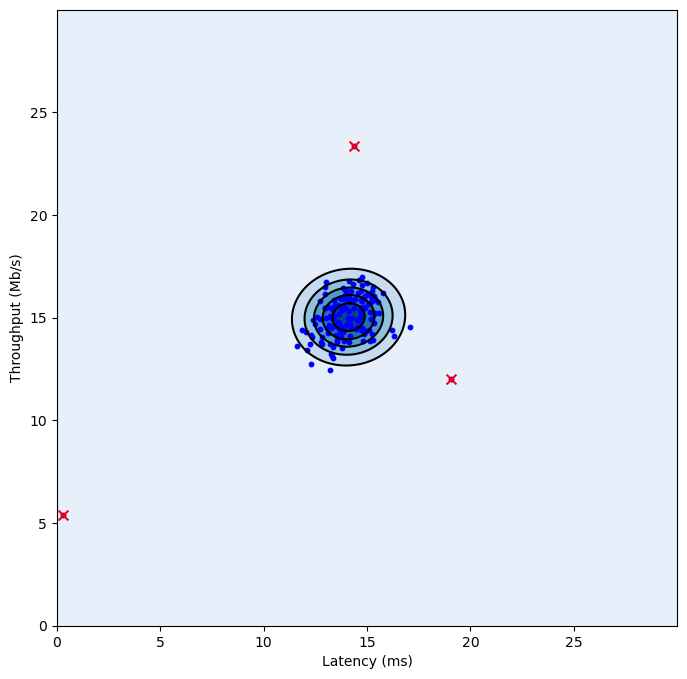

In [16]:
data = pd.DataFrame(Xtest, columns=['Latency', 'Throughput'])
data['y_pred'] = y_pred

fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(x, y, multi_normal.pdf(pos), cmap='Blues')
ax.contour(x, y, multi_normal.pdf(pos), colors='black')

ax.set_xlabel('Latency (ms)')
ax.set_ylabel('Throughput (Mb/s)')
ax.scatter(Xtest[:, 0], Xtest[:, 1], c='b', s=10)

anamoly_data = data[data['y_pred'] == 1]
ax.scatter(anamoly_data['Latency'], anamoly_data['Throughput'], marker='x',c='r', s=50)

plt.show()

In [17]:
%whos

Variable                        Type                          Data/Info
-----------------------------------------------------------------------
X                               ndarray                       307x2: 614 elems, type `float64`, 4912 bytes
Xtest                           ndarray                       154x2: 308 elems, type `float64`, 2464 bytes
Xval                            ndarray                       153x2: 306 elems, type `float64`, 2448 bytes
anamoly_data                    DataFrame                           Latency  Throughput<...>34988   12.028949       1
ax                              Axes                          Axes(0.125,0.11;0.775x0.77)
classification_report           function                      <function classification_<...>report at 0x7fcf7d3af130>
cov                             ndarray                       2x2: 4 elems, type `float64`, 32 bytes
data                            DataFrame                            Latency  Throughpu<...>n\n[154 rows x 3

In [18]:
%reset_selective -f X,Xtest,Xval,cov,data,e,fs,y_pred,mat

# High Dimension Data

In [19]:
mat = loadmat('data/ex8data2.mat')

X = mat['X']
Xval, Xtest, yval, ytest = train_test_split(mat.get('Xval'), mat.get('yval').ravel(), test_size=0.5)

In [21]:
e, fs = select_threshold(X, Xval, yval)
print('Best epsion: {}\nBest F-Score on validation data: {}'.format(e, fs))

Best epsion: 8.151899915691223e-20
Best F-Score on validation data: 0.4


In [22]:
multi_normal, y_pred = predict(X, Xval, e, Xtest, ytest)

              precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.71      0.83      0.77         6

    accuracy                           0.94        50
   macro avg       0.85      0.89      0.87        50
weighted avg       0.95      0.94      0.94        50



In [23]:
print('find {} anamolies in Xtest data set'.format(y_pred.sum()))

find 7 anamolies in Xtest data set


In [24]:
yval = multi_normal.pdf(X)
y_pred = (yval <= e).astype('int')
print('find {} anamolies in X data set'.format(y_pred.sum()))

find 25 anamolies in X data set
